# Figure 3: Comparison of Km plots for 50% and 75% enriched

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import statistics
from  tqdm import tqdm
import scipy.stats as ss
from lifelines import KaplanMeierFitter, statistics

In [3]:
PROJECT = "KIRC"

expressions = pd.read_csv(f"../TCGA/TCGA-{PROJECT}-expressions.tsv", sep="\t", index_col=[0])
expressions.index.name = "gene"
ssgsea = pd.read_csv(f"../TCGA/TCGA-{PROJECT}-ssGSEA.tsv", sep="\t", index_col=[0])
metadata = pd.read_csv(f"../TCGA/TCGA-{PROJECT}-metadata.tsv", sep="\t", index_col=[0])

In [5]:
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from calculate_ssGSEA_scores import get_hallmark_genesets
from single_sample_gsea import ss_gsea as ssGSEA

hallmark_genesets = get_hallmark_genesets(expressions.index.values, "..")

In [12]:
def normalize(expressions):
    exp = np.log(expressions.T + 1)
    exp = (exp - exp.mean(axis=0)) / exp.std(axis=0)
    exp = exp.dropna(axis=1)
    exp = exp.fillna(0)
    return exp.T

def bootstrap_logrank_values(ssgsea, metadata, M_BOOTSTRAP, geneset, split_perc, seed=0):
    np.random.seed(seed)

    s = ssgsea[geneset].to_frame()
    m = metadata.loc[s.index.values]

    bootstrap_values = []

    for _ in range(M_BOOTSTRAP):

        ids = np.random.choice(np.arange(len(s)), size=len(s), replace=True)
        s_boot = s.iloc[ids]
        m_boot = m.iloc[ids]

        up_ids = s_boot[geneset] > np.percentile(ssgsea[geneset], 100 - split_perc)
        up_score = m_boot.loc[up_ids]
        down_score = m_boot.loc[~up_ids]

        bootstrap_values += [
            statistics.logrank_test(
                up_score["time"], down_score["time"],
                event_observed_A=up_score["event"], event_observed_B=down_score["event"]
            )
        ]
    
    return bootstrap_values

def ssgsea_logrank_with_bootstrap_splits(expressions, metadata, genesets, M_BOOTSTRAP=1000, rnd_seed=0, splits=[50]) -> dict:

    exp = normalize(expressions)
    ssgsea = ssGSEA(exp, genesets)
    metadata = metadata.loc[ssgsea.index.values]

    results = {}

    for geneset in genesets.keys():

        results[geneset] = {} 

        for split_perc in tqdm(splits):

            results[geneset][split_perc] = {}

            up_ids = ssgsea[geneset] > np.percentile(ssgsea[geneset].values, 100-split_perc)
            up_score = metadata.loc[up_ids]
            down_score = metadata.loc[~up_ids]

            results[geneset][split_perc]["truth"] = statistics.logrank_test(
                up_score["time"], down_score["time"], event_observed_A=up_score["event"], event_observed_B=down_score["event"]
            )

            results[geneset][split_perc]["bootstrap"] = bootstrap_logrank_values(
                ssgsea, metadata, M_BOOTSTRAP, geneset, split_perc, rnd_seed
            )
        
    return results

## Calculate ssGSEA-logrank with bootstrap values

In [13]:
SPLITS = np.arange(5, 100, 5)
geneset = "HALLMARK_ADIPOGENESIS"
GENESETS = {geneset: hallmark_genesets[geneset]}

results = ssgsea_logrank_with_bootstrap_splits(
    expressions, metadata, GENESETS, M_BOOTSTRAP=100, rnd_seed=1, splits=SPLITS)

100%|██████████| 19/19 [01:27<00:00,  4.63s/it]


In [14]:
exp = normalize(expressions)
ssgsea = ssGSEA(exp, GENESETS)
metadata = metadata.loc[ssgsea.index.values]

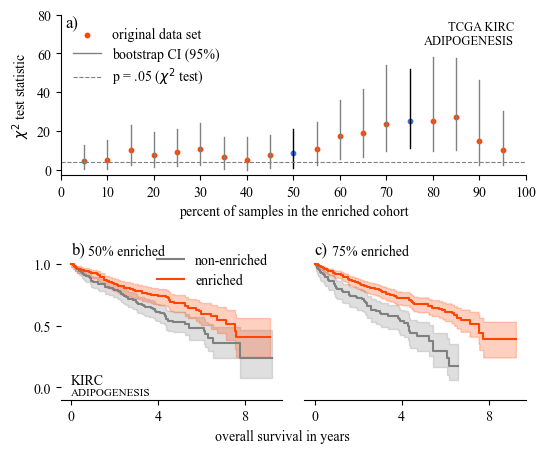

In [15]:
plt.rcParams["font.family"] = "Times New Roman"

f, axs = plt.subplots(2, 2, figsize=(6,5), gridspec_kw={"wspace":0.1, "hspace":0.4})

gs = axs[0, 1].get_gridspec()
for ax in axs[0, :]:
    ax.remove()
axbig = f.add_subplot(gs[0, :])
ax = axs[1]


# top plot

for x in results[geneset].keys():

    truth = results[geneset][x]["truth"]
    boots = results[geneset][x]["bootstrap"]
    boots_values = [x.test_statistic for x in boots]
    
    axbig.scatter(x, truth.test_statistic, s=10, color="orangered" if x not in [50, 75] else "royalblue",
        label=None if x != 5 else "original data set")

    CI_LOW = np.percentile(boots_values, 2.5)
    CI_HIGH = np.percentile(boots_values, 97.5)
    axbig.plot([x,x], [CI_LOW, CI_HIGH], color="gray" if x not in [50, 75] else "k", lw=1,
            label=None if x != 5 else "bootstrap CI (95%)")

axbig.axhline(3.84, 0, 100, ls="dashed", lw=0.8, color="gray", label="p = .05 ($\chi^2$ test)")
axbig.set_ylim(top=80)
axbig.legend(fontsize=10, frameon=False, labelspacing=0.4)

axbig.set_ylabel("$\chi^2$ test statistic", fontsize=10)
axbig.set_xlabel("percent of samples in the enriched cohort", fontsize=10)

axbig.text(97.5, 70, f"TCGA {PROJECT}\n{' '.join(geneset.split('_')[1:])}", fontsize=9,
        verticalalignment="center", horizontalalignment="right")

_ = axbig.set_xticks(np.arange(0,101,10))

axbig.text(1, 80, "a)", fontsize=12, verticalalignment="top")

axbig.spines["top"].set_visible(False)
axbig.spines["right"].set_visible(False)


# Bottom plots

FOUR_YEARS = 4*365
RIGHT_XTICK = np.array([2, 2])
AXES_LABELS = list("bc")

split_percentiles = [50, 75]

for i in range(2):

    group = (ssgsea[geneset] > np.percentile(ssgsea[geneset], 100 - split_percentiles[i]))
    group_names = ["non-enriched", "enriched"] # for 0 and 1

    # PLOT KM
    T = metadata["time"]
    E = metadata["event"]

    kmf = KaplanMeierFitter()
    kmf.fit(T[-group], event_observed=E[-group], label=group_names[0])
    kmf.plot_survival_function(ax=ax[i], color="gray")
    
    kmf.fit(T[group], event_observed=E[group], label=group_names[1])
    kmf.plot_survival_function(ax=ax[i], color="orangered")


    # adjust plots
    ax[i].set_ylim(-0.1, 1.2)
    
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
    ax[i].spines["right"].set_visible(False)

    ax[i].set_yticks([0, 0.5, 1])
    ax[i].set_xticks(np.array([0, RIGHT_XTICK[i]//2, RIGHT_XTICK[i]])*FOUR_YEARS)
    ax[i].set_xticklabels(np.array([0, RIGHT_XTICK[i]//2, RIGHT_XTICK[i]])*4)

    ax[i].text(0, 1.05, f"{AXES_LABELS[i]})", fontsize=12, verticalalignment="bottom")
    ax[i].text(0.2*FOUR_YEARS, 1.05, f"{split_percentiles[i]}% enriched", fontsize=10, verticalalignment="bottom",
                horizontalalignment="left")
    
    if i == 0:
        ax[i].text(0, 0, PROJECT, fontsize=10, verticalalignment="bottom")
        ax[i].text(0, 0, " ".join(geneset.split("_")[1:]), fontsize=8, verticalalignment="top")

    if i != 0:
        ax[i].get_legend().remove()
    else:
        ax[i].legend(fontsize=10, frameon=False, loc=1, labelspacing=0.4, borderpad=0.5)

    if i == 0:
        ax[i].set_xlabel("overall survival in years", fontsize=10, x=1)
    else:
        ax[i].set_xlabel(None)
    
    if i not in [0, 3]:
        ax[i].set_yticks([])
        ax[i].set_yticklabels([])


f.savefig("../figures/figure3.png", bbox_inches="tight", dpi=500)